In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the data frames

log_pr = pd.read_pickle("./log_price.df")
volu = pd.read_pickle("./volume_usd.df")

<AxesSubplot:xlabel='timestamp'>

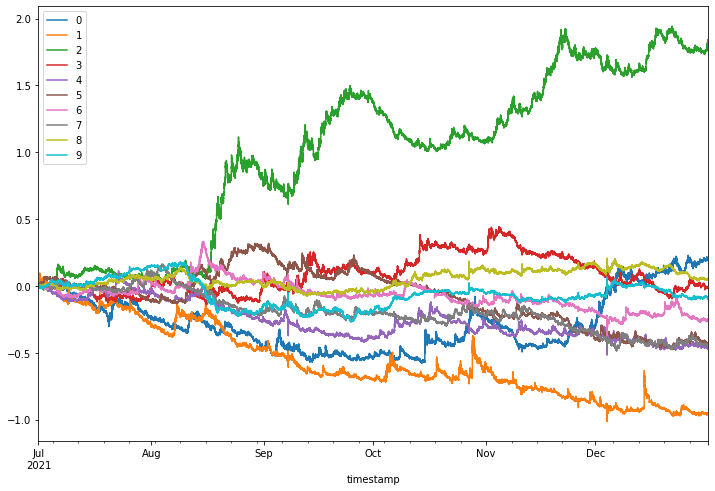

In [3]:
# Check the log-prices of the 10 assets

log_pr.plot(figsize=(12, 8))

In [4]:
# An example of get_r_hat

def get_r_hat(A, B): 
    """
        A: 1440-by-10 dataframe of log prices with columns log_pr_0, ... , log_pr_9
        B: 1440-by-10 dataframe of trading volumes with columns volu_0, ... , volu_9    
        return: a numpy array of length 10, corresponding to the predictions for the forward 30-minutes returns of assets 0, 1, 2, ..., 9
    """
    
    return -(A.iloc[-1] - A.iloc[-30]).values # Use the negative 30-minutes backward log-returns to predict the 30-minutes forward log-returns

In [5]:
# Generate r_hat every 10 minutes

t0 = time.time()
dt = datetime.timedelta(days=1)
r_hat = pd.DataFrame(index=log_pr.index[30::10], columns=np.arange(10), dtype=np.float64)
for t in log_pr.index[30::10]: # compute the predictions every 10 minutes
    r_hat.loc[t, :] = get_r_hat(log_pr.loc[(t - dt):t], volu.loc[(t - dt):t])
t_used = time.time() - t0
print(t_used)
    

20.61443328857422


In [6]:
# Compute true forward log_returns every 10 minutes
r_fwd = (log_pr.shift(-30) - log_pr).iloc[30::10].rename(columns={f"log_pr_{i}": i for i in range(10)})


In [7]:
# Correlation for every asset

r_fwd.corrwith(r_hat)

0    0.028584
1    0.063681
2    0.005824
3    0.036314
4    0.096442
5    0.035261
6    0.067607
7    0.022329
8    0.105946
9    0.053176
dtype: float64

In [8]:
# Overall correlation (The ranking is based on this metric on the testing dataset)

r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
r_hat_all = r_hat.iloc[:-3].values.ravel()
np.corrcoef(r_fwd_all, r_hat_all)[0, 1]

0.040118694541047606

In [12]:
log_pr_test, volu_test = log_pr.iloc[-1440*30:], volu.iloc[-1440*30:]
log_pr_train, volu_train = log_pr.iloc[1440*30:-1440*30], volu.iloc[1440*30:-1440*30]
print(log_pr_test.shape, volu_test.shape, log_pr_train.shape, volu_train.shape)
print(log_pr_train.shape[0] / log_pr_test.shape[0])
print(np.intersect1d(log_pr_train.index, log_pr_test.index))

(43200, 10) (43200, 10) (178560, 10) (178560, 10)
4.133333333333334
[]


In [30]:
def validate(get_r_hat, log_pr, volu):
    from tqdm import tqdm
    # Generate r_hat every 10 minutes

    t0 = time.time()
    dt = datetime.timedelta(days=1)
    r_hat = pd.DataFrame(index=log_pr.index[1440::10], columns=np.arange(10), dtype=np.float64)
    for t in tqdm(log_pr.index[1440::10]): # compute the predictions every 10 minutes
        r_hat.loc[t, :] = get_r_hat(log_pr.loc[(t - dt):t], volu.loc[(t - dt):t])
    t_used = time.time() - t0
    print(t_used)

    # Correlation for every asset
    r_fwd = (log_pr.shift(-30) - log_pr).iloc[1440::10].rename(columns={f"log_pr_{i}": i for i in range(10)})

    print(r_fwd.corrwith(r_hat))

    # Overall correlation (The ranking is based on this metric on the testing dataset)

    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()

    overall = np.corrcoef(r_fwd_all, r_hat_all)[0, 1]
    print(overall)
    return overall
            

In [18]:
# An example of get_r_hat

def negative_return(A, B): 
    """
        A: 1440-by-10 dataframe of log prices with columns log_pr_0, ... , log_pr_9
        B: 1440-by-10 dataframe of trading volumes with columns volu_0, ... , volu_9    
        return: a numpy array of length 10, corresponding to the predictions for the forward 30-minutes returns of assets 0, 1, 2, ..., 9
    """
    
    return -(A.iloc[-1] - A.iloc[-30]).values # Use the negative 30-minutes backward log-returns to predict the 30-minutes forward log-returns

In [19]:
validate(negative_return, log_pr_train, volu_train)

15.431012153625488
0    0.041456
1    0.070355
2    0.004268
3    0.038715
4    0.102924
5    0.037254
6    0.092971
7    0.039037
8    0.107920
9    0.047928
dtype: float64
0.04237989395106577


In [22]:
sma_window = 32
def SimpleMA(A, B):
    sma = A.rolling(sma_window).mean()
    return sma.values[-1] - A.iloc[-1].values

In [23]:
validate(SimpleMA, log_pr_train, volu_train)

51.181989669799805
0    0.037954
1    0.062356
2    0.009559
3    0.042282
4    0.120140
5    0.051254
6    0.094681
7    0.050127
8    0.121863
9    0.057139
dtype: float64
0.046736419680886834


100%|██████████| 17712/17712 [00:52<00:00, 335.04it/s]


52.88034987449646
0    0.020104
1    0.016448
2    0.019459
3    0.020330
4    0.080917
5    0.041692
6    0.053550
7    0.006632
8    0.064304
9    0.029801
dtype: float64
0.02876754448850684


100%|██████████| 4176/4176 [00:13<00:00, 319.45it/s]


13.080358982086182
0    0.019162
1    0.033937
2    0.024784
3    0.034758
4    0.026991
5    0.026223
6    0.050142
7    0.009687
8    0.042722
9   -0.006570
dtype: float64
0.027120652073339087


100%|██████████| 17712/17712 [00:54<00:00, 327.28it/s]


54.12873721122742
0    0.025029
1    0.010546
2    0.020927
3    0.035851
4    0.087767
5    0.062921
6    0.067781
7    0.038372
8    0.102536
9    0.058531
dtype: float64
0.037166074457741186


100%|██████████| 4176/4176 [00:12<00:00, 327.78it/s]


12.744907140731812
0    0.055108
1    0.110912
2    0.005158
3    0.041688
4   -0.019778
5    0.071751
6    0.100636
7   -0.006763
8   -0.011408
9    0.057068
dtype: float64
0.04644062050144209


100%|██████████| 17712/17712 [00:50<00:00, 349.72it/s]


50.674302101135254
0    0.026919
1    0.027365
2    0.018735
3    0.039336
4    0.102303
5    0.057868
6    0.082362
7    0.048287
8    0.111258
9    0.050654
dtype: float64
0.04144893339935688


100%|██████████| 4176/4176 [00:12<00:00, 343.93it/s]


12.14204740524292
0    0.041764
1    0.129696
2   -0.006168
3    0.027165
4   -0.007044
5    0.126359
6    0.055853
7   -0.001938
8    0.009405
9    0.026635
dtype: float64
0.04685803728922339


100%|██████████| 17712/17712 [00:50<00:00, 347.47it/s]


50.981600761413574
0    0.029031
1    0.039021
2    0.015781
3    0.041517
4    0.111325
5    0.057903
6    0.085274
7    0.050682
8    0.116827
9    0.056689
dtype: float64
0.04381095825741371


100%|██████████| 4176/4176 [00:11<00:00, 368.07it/s]


11.35379409790039
0    0.033833
1    0.125233
2   -0.010653
3    0.018672
4    0.011363
5    0.136069
6    0.048860
7   -0.004110
8    0.015682
9    0.024631
dtype: float64
0.045000625041503234


100%|██████████| 17712/17712 [00:51<00:00, 345.86it/s]


51.21142292022705
0    0.031931
1    0.050271
2    0.014676
3    0.041722
4    0.114773
5    0.055271
6    0.088322
7    0.052077
8    0.118609
9    0.054119
dtype: float64
0.045523692882289114


100%|██████████| 4176/4176 [00:12<00:00, 332.33it/s]


12.581406593322754
0    0.026486
1    0.111974
2   -0.015899
3    0.010594
4    0.024297
5    0.138397
6    0.044645
7   -0.004733
8    0.029206
9    0.022378
dtype: float64
0.04108294185602585


100%|██████████| 17712/17712 [00:55<00:00, 317.86it/s]


55.73031425476074
0    0.035392
1    0.056569
2    0.011958
3    0.042462
4    0.118741
5    0.053892
6    0.090645
7    0.051156
8    0.120750
9    0.057074
dtype: float64
0.04634856962811072


100%|██████████| 4176/4176 [00:12<00:00, 326.21it/s]


12.80954122543335
0    0.021599
1    0.098676
2   -0.019413
3    0.002711
4    0.043064
5    0.133428
6    0.043396
7   -0.004705
8    0.034142
9    0.020127
dtype: float64
0.03823050829581484


100%|██████████| 17712/17712 [00:53<00:00, 328.10it/s]


53.99230909347534
0    0.037954
1    0.062356
2    0.009559
3    0.042282
4    0.120140
5    0.051254
6    0.094681
7    0.050127
8    0.121863
9    0.057139
dtype: float64
0.046736419680886834


100%|██████████| 4176/4176 [00:12<00:00, 328.19it/s]


12.72418761253357
0    0.018770
1    0.085074
2   -0.023178
3   -0.000950
4    0.057534
5    0.125199
6    0.046193
7   -0.005912
8    0.047812
9    0.030465
dtype: float64
0.036415165317716776


100%|██████████| 17712/17712 [00:53<00:00, 329.99it/s]


53.67999315261841
0    0.040631
1    0.066142
2    0.007060
3    0.042812
4    0.119848
5    0.048904
6    0.097618
7    0.049009
8    0.122075
9    0.057904
dtype: float64
0.04671541691569899


100%|██████████| 4176/4176 [00:12<00:00, 325.24it/s]


12.847612380981445
0    0.013742
1    0.075420
2   -0.023846
3   -0.006950
4    0.072936
5    0.116925
6    0.044162
7   -0.006895
8    0.057644
9    0.035905
dtype: float64
0.03471728890102876


100%|██████████| 17712/17712 [00:54<00:00, 326.79it/s]


54.20808792114258
0    0.042662
1    0.068407
2    0.005948
3    0.042781
4    0.117431
5    0.045901
6    0.100108
7    0.047007
8    0.120978
9    0.056356
dtype: float64
0.04640369195391282


100%|██████████| 4176/4176 [00:13<00:00, 320.00it/s]


13.054198980331421
0    0.009660
1    0.068254
2   -0.023651
3   -0.011855
4    0.085205
5    0.114539
6    0.043725
7   -0.008428
8    0.071375
9    0.047852
dtype: float64
0.03442865487487104


100%|██████████| 17712/17712 [00:53<00:00, 334.00it/s]


53.05312728881836
0    0.044651
1    0.070472
2    0.004971
3    0.042599
4    0.115282
5    0.042874
6    0.101729
7    0.044336
8    0.119375
9    0.055628
dtype: float64
0.046034642536377623


100%|██████████| 4176/4176 [00:10<00:00, 385.10it/s]


10.85241436958313
0    0.006264
1    0.057718
2   -0.022963
3   -0.016152
4    0.097480
5    0.112082
6    0.040474
7   -0.009509
8    0.081777
9    0.055094
dtype: float64
0.03330762358951797


100%|██████████| 17712/17712 [00:45<00:00, 391.56it/s]


45.242422342300415
0    0.046240
1    0.072248
2    0.005270
3    0.042360
4    0.112824
5    0.039231
6    0.103470
7    0.040798
8    0.117365
9    0.054128
dtype: float64
0.045847397391541804


100%|██████████| 4176/4176 [00:10<00:00, 386.98it/s]


10.797216415405273
0    0.004130
1    0.044745
2   -0.022457
3   -0.017825
4    0.106479
5    0.112407
6    0.036124
7   -0.010747
8    0.093521
9    0.064444
dtype: float64
0.03199897379300292


100%|██████████| 17712/17712 [00:45<00:00, 389.99it/s]


45.41671800613403
0    0.047634
1    0.074023
2    0.006115
3    0.041903
4    0.110627
5    0.035833
6    0.104384
7    0.036985
8    0.114863
9    0.053174
dtype: float64
0.045761311855417104


100%|██████████| 4176/4176 [00:10<00:00, 385.21it/s]


10.849847793579102
0    0.001427
1    0.032042
2   -0.020960
3   -0.019146
4    0.116475
5    0.113578
6    0.031748
7   -0.011894
8    0.104110
9    0.071844
dtype: float64
0.03086578957782797


100%|██████████| 17712/17712 [00:45<00:00, 388.56it/s]


45.59928059577942
0    0.048567
1    0.075564
2    0.007683
3    0.041290
4    0.108776
5    0.032856
6    0.104937
7    0.032687
8    0.111847
9    0.051371
dtype: float64
0.04576763503807116


100%|██████████| 4176/4176 [00:10<00:00, 387.41it/s]


10.779201030731201
0   -0.000904
1    0.018641
2   -0.019483
3   -0.018907
4    0.123414
5    0.112145
6    0.024493
7   -0.012910
8    0.114006
9    0.079100
dtype: float64
0.028961962637463517


100%|██████████| 17712/17712 [00:45<00:00, 389.49it/s]


45.506470680236816
0    0.049330
1    0.076979
2    0.009199
3    0.040275
4    0.107321
5    0.030263
6    0.104847
7    0.027826
8    0.109018
9    0.050453
dtype: float64
0.04571330789024751


100%|██████████| 4176/4176 [00:10<00:00, 391.04it/s]


10.679242372512817
0   -0.002771
1    0.005709
2   -0.017796
3   -0.017674
4    0.130174
5    0.110728
6    0.018626
7   -0.013980
8    0.122819
9    0.084702
dtype: float64
0.027309986236697753


100%|██████████| 17712/17712 [00:45<00:00, 387.95it/s]


45.671300649642944
0    0.050249
1    0.078178
2    0.011008
3    0.039430
4    0.106163
5    0.028417
6    0.104909
7    0.023338
8    0.106610
9    0.049461
dtype: float64
0.0458853434692888


100%|██████████| 4176/4176 [00:10<00:00, 386.64it/s]


10.800640106201172
0   -0.003647
1   -0.006813
2   -0.016664
3   -0.015079
4    0.135089
5    0.107344
6    0.012392
7   -0.014494
8    0.130283
9    0.089731
dtype: float64
0.025488191350111735


100%|██████████| 17712/17712 [00:45<00:00, 388.76it/s]


45.56591844558716
0    0.050709
1    0.078537
2    0.012675
3    0.038819
4    0.105250
5    0.026955
6    0.104839
7    0.018842
8    0.104889
9    0.049389
dtype: float64
0.04595887313833158


100%|██████████| 4176/4176 [00:10<00:00, 390.75it/s]


10.687012910842896
0   -0.004720
1   -0.015293
2   -0.014995
3   -0.012637
4    0.139315
5    0.104763
6    0.007556
7   -0.015135
8    0.136708
9    0.093715
dtype: float64
0.024362379408014768


100%|██████████| 17712/17712 [00:45<00:00, 388.78it/s]


45.55736804008484
0    0.050986
1    0.078528
2    0.014659
3    0.038143
4    0.104120
5    0.026159
6    0.105108
7    0.014797
8    0.103459
9    0.049259
dtype: float64
0.04614652735410256


100%|██████████| 4176/4176 [00:10<00:00, 389.79it/s]


10.722900867462158
0   -0.005652
1   -0.020642
2   -0.013132
3   -0.010586
4    0.142588
5    0.102992
6    0.002356
7   -0.015028
8    0.140998
9    0.096544
dtype: float64
0.02359493296333901


100%|██████████| 17712/17712 [00:45<00:00, 389.88it/s]


45.42890930175781
0    0.051044
1    0.077370
2    0.016453
3    0.037481
4    0.103148
5    0.025938
6    0.105276
7    0.011128
8    0.102636
9    0.049649
dtype: float64
0.04619128480515935


100%|██████████| 4176/4176 [00:10<00:00, 385.18it/s]


10.841725826263428
0   -0.006481
1   -0.024945
2   -0.011061
3   -0.008330
4    0.144740
5    0.101192
6   -0.001904
7   -0.014707
8    0.143743
9    0.097977
dtype: float64
0.022895645031596974


100%|██████████| 17712/17712 [00:45<00:00, 386.38it/s]


45.84106183052063
0    0.051002
1    0.075913
2    0.018547
3    0.036657
4    0.101917
5    0.025825
6    0.105412
7    0.007894
8    0.102215
9    0.050083
dtype: float64
0.04629283347079814


100%|██████████| 4176/4176 [00:10<00:00, 387.52it/s]


10.776237964630127
0   -0.007006
1   -0.028296
2   -0.009245
3   -0.006708
4    0.146694
5    0.100675
6   -0.005121
7   -0.014154
8    0.144862
9    0.098403
dtype: float64
0.022390169213056865


100%|██████████| 17712/17712 [00:45<00:00, 388.50it/s]


45.59023332595825
0    0.050952
1    0.074003
2    0.020363
3    0.035616
4    0.100641
5    0.025935
6    0.105393
7    0.005101
8    0.101811
9    0.050554
dtype: float64
0.04624686044568484


100%|██████████| 4176/4176 [00:10<00:00, 389.58it/s]


10.719350099563599
0   -0.007573
1   -0.030963
2   -0.007394
3   -0.004870
4    0.148005
5    0.100246
6   -0.007988
7   -0.013579
8    0.145371
9    0.098402
dtype: float64
0.02194085367136728


100%|██████████| 17712/17712 [2:46:34<00:00,  1.77it/s]   


9994.302127122879
0    0.050816
1    0.072141
2    0.022193
3    0.034319
4    0.099017
5    0.025913
6    0.105279
7    0.002587
8    0.101272
9    0.050957
dtype: float64
0.046151077937893734


100%|██████████| 4176/4176 [00:07<00:00, 572.87it/s]


7.289661645889282
0   -0.007615
1   -0.033297
2   -0.005472
3   -0.003531
4    0.149130
5    0.099609
6   -0.009854
7   -0.013037
8    0.145303
9    0.098128
dtype: float64
0.02165634230827215


100%|██████████| 17712/17712 [00:26<00:00, 660.67it/s]


26.815669298171997
0    0.050771
1    0.070563
2    0.023594
3    0.032659
4    0.097286
5    0.026034
6    0.105110
7    0.000354
8    0.100657
9    0.051175
dtype: float64
0.045937146349233196


100%|██████████| 4176/4176 [00:06<00:00, 672.10it/s]


6.213379383087158
0   -0.007470
1   -0.034543
2   -0.003871
3   -0.001827
4    0.150158
5    0.098351
6   -0.011598
7   -0.012549
8    0.144563
9    0.097613
dtype: float64
0.02150287949885061


100%|██████████| 17712/17712 [00:26<00:00, 674.76it/s]


26.25321650505066
0    0.050764
1    0.069380
2    0.024947
3    0.030824
4    0.095404
5    0.025916
6    0.104762
7   -0.001603
8    0.100033
9    0.051484
dtype: float64
0.04573224622926512


100%|██████████| 4176/4176 [00:06<00:00, 683.05it/s]


6.117792844772339
0   -0.006741
1   -0.034734
2   -0.002734
3   -0.000028
4    0.151078
5    0.096313
6   -0.012419
7   -0.012347
8    0.143640
9    0.097127
dtype: float64
0.021593436024426992


100%|██████████| 17712/17712 [00:46<00:00, 380.76it/s]


46.52117419242859
0    0.050536
1    0.068848
2    0.025898
3    0.028867
4    0.093494
5    0.025799
6    0.104266
7   -0.003618
8    0.099186
9    0.051702
dtype: float64
0.04542805915153061


100%|██████████| 4176/4176 [00:12<00:00, 321.44it/s]


12.995365858078003
0   -0.005951
1   -0.034254
2   -0.001878
3    0.001833
4    0.152130
5    0.094322
6   -0.013184
7   -0.012368
8    0.142507
9    0.096546
dtype: float64
0.021783099529015075


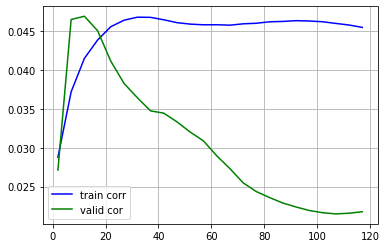

In [35]:
# optimal window size
train_cor = []
valid_cor = []
for sma_w in range(2, 120, 5):
    sma_window = sma_w
    train_cor.append(validate(SimpleMA, log_pr_train, volu_train))
    valid_cor.append(validate(SimpleMA, log_pr_test, volu_test))

import matplotlib.pyplot as plt
plt.plot(list(range(2, 120, 5)), train_cor, 'b-', label='train corr')
plt.plot(list(range(2, 120, 5)), valid_cor, 'g-', label='valid cor')
plt.legend()
plt.grid()
plt.show()

In [24]:
ema_window = 32
def ExponentialMA(A, B):
    ema = A.ewm(ema_window, adjust=False).mean()
    return ema.values[-1] - A.iloc[-1].values

In [25]:
validate(ExponentialMA, log_pr_train, volu_train)

28.761027097702026
0    0.049080
1    0.074991
2    0.016172
3    0.037814
4    0.111938
5    0.038123
6    0.108582
7    0.023159
8    0.116915
9    0.057315
dtype: float64
0.04872933991888714


100%|██████████| 17712/17712 [00:29<00:00, 600.31it/s]


29.517678260803223
0    0.024465
1    0.017600
2    0.022989
3    0.036835
4    0.090124
5    0.063898
6    0.071225
7    0.035919
8    0.107176
9    0.050489
dtype: float64
0.03923188742216085


100%|██████████| 4176/4176 [00:06<00:00, 629.76it/s]


6.631098747253418
0    0.046608
1    0.102246
2    0.009652
3    0.041266
4   -0.011756
5    0.078392
6    0.073787
7    0.001688
8    0.012807
9    0.032587
dtype: float64
0.04323939717510416


100%|██████████| 17712/17712 [00:29<00:00, 603.83it/s]


29.33293342590332
0    0.032870
1    0.041898
2    0.017051
3    0.043337
4    0.113953
5    0.060904
6    0.090660
7    0.050346
8    0.121989
9    0.057861
dtype: float64
0.04619609990794094


100%|██████████| 4176/4176 [00:06<00:00, 613.74it/s]


6.804237365722656
0    0.035770
1    0.115910
2   -0.010313
3    0.020133
4    0.018658
5    0.128544
6    0.058681
7   -0.004170
8    0.025739
9    0.032424
dtype: float64
0.04522135248886869


100%|██████████| 17712/17712 [00:32<00:00, 549.28it/s]


32.24571418762207
0    0.039039
1    0.057033
2    0.013423
3    0.044536
4    0.119972
5    0.054787
6    0.098942
7    0.049109
8    0.125168
9    0.058844
dtype: float64
0.04829058466992818


100%|██████████| 4176/4176 [00:07<00:00, 567.88it/s]


7.361669301986694
0    0.023934
1    0.094459
2   -0.016674
3    0.005835
4    0.052948
5    0.130916
6    0.048355
7   -0.006754
8    0.051776
9    0.042382
dtype: float64
0.041255010378890525


100%|██████████| 17712/17712 [00:31<00:00, 555.15it/s]


31.904967784881592
0    0.043381
1    0.065423
2    0.012646
3    0.044043
4    0.120170
5    0.049003
6    0.103750
7    0.043439
8    0.124309
9    0.058500
dtype: float64
0.04901927559328957


100%|██████████| 4176/4176 [00:07<00:00, 569.36it/s]


7.343031406402588
0    0.015716
1    0.070626
2   -0.017872
3   -0.001242
4    0.079060
5    0.127473
6    0.039078
7   -0.008848
8    0.074500
9    0.055022
dtype: float64
0.03772000422576499


100%|██████████| 17712/17712 [00:30<00:00, 576.76it/s]


30.709616899490356
0    0.046248
1    0.070216
2    0.013439
3    0.042533
4    0.118203
5    0.044361
6    0.106544
7    0.036483
8    0.122093
9    0.057985
dtype: float64
0.0492097265411615


100%|██████████| 4176/4176 [00:06<00:00, 597.17it/s]


6.992981910705566
0    0.010243
1    0.050145
2   -0.016844
3   -0.003817
4    0.097849
5    0.123207
6    0.030523
7   -0.010375
8    0.091997
9    0.065791
dtype: float64
0.03495114537981549


100%|██████████| 17712/17712 [00:29<00:00, 604.56it/s]


29.29736614227295
0    0.048043
1    0.073102
2    0.014788
3    0.040366
4    0.115294
5    0.040821
6    0.108019
7    0.029554
8    0.119510
9    0.057591
dtype: float64
0.04908245577829113


100%|██████████| 4176/4176 [00:07<00:00, 588.23it/s]


7.099276065826416
0    0.006739
1    0.034253
2   -0.014947
3   -0.003816
4    0.111063
5    0.118839
6    0.023369
7   -0.011481
8    0.104904
9    0.074176
dtype: float64
0.032918707402416494


100%|██████████| 17712/17712 [00:29<00:00, 602.38it/s]


29.411583185195923
0    0.049080
1    0.074991
2    0.016172
3    0.037814
4    0.111938
5    0.038123
6    0.108582
7    0.023159
8    0.116915
9    0.057315
dtype: float64
0.04872933991888714


100%|██████████| 4176/4176 [00:06<00:00, 597.83it/s]


7.006994724273682
0    0.004608
1    0.022584
2   -0.012830
3   -0.002407
4    0.120137
5    0.114505
6    0.017821
7   -0.012324
8    0.114336
9    0.080605
dtype: float64
0.03149318927157574


100%|██████████| 17712/17712 [00:29<00:00, 603.70it/s]


29.339096784591675
0    0.049584
1    0.076363
2    0.017376
3    0.035087
4    0.108373
5    0.036022
6    0.108490
7    0.017445
8    0.114433
9    0.057098
dtype: float64
0.04821185257140388


100%|██████████| 4176/4176 [00:07<00:00, 563.49it/s]


7.427511215209961
0    0.003424
1    0.014342
2   -0.010801
3   -0.000284
4    0.126139
5    0.110258
6    0.013772
7   -0.013009
8    0.121247
9    0.085564
dtype: float64
0.030531423511195463


100%|██████████| 17712/17712 [00:31<00:00, 555.36it/s]


31.893112659454346
0    0.049714
1    0.077461
2    0.018337
3    0.032332
4    0.104735
5    0.034334
6    0.107921
7    0.012414
8    0.112110
9    0.056887
dtype: float64
0.04757824140369485


100%|██████████| 4176/4176 [00:07<00:00, 533.02it/s]


7.842573165893555
0    0.002892
1    0.008736
2   -0.008989
3    0.002141
4    0.129857
5    0.106136
6    0.010996
7   -0.013594
8    0.126335
9    0.089420
dtype: float64
0.029909726449128392


100%|██████████| 17712/17712 [00:29<00:00, 608.06it/s]


29.136845588684082
0    0.049582
1    0.078407
2    0.019059
3    0.029647
4    0.101104
5    0.032931
6    0.107002
7    0.008012
8    0.109958
9    0.056646
dtype: float64
0.04686642929157632


100%|██████████| 4176/4176 [00:06<00:00, 612.32it/s]


6.82794976234436
0    0.002810
1    0.005106
2   -0.007433
3    0.004624
4    0.131873
5    0.102171
6    0.009248
7   -0.014107
8    0.130084
9    0.092430
dtype: float64
0.02953141143489745


100%|██████████| 17712/17712 [00:28<00:00, 624.60it/s]


28.36519956588745
0    0.049267
1    0.079258
2    0.019570
3    0.027092
4    0.097533
5    0.031727
6    0.105828
7    0.004167
8    0.107974
9    0.056355
dtype: float64
0.046105393930127074


100%|██████████| 4176/4176 [00:07<00:00, 535.29it/s]


7.801320552825928
0    0.003036
1    0.002937
2   -0.006130
3    0.007023
4    0.132626
5    0.098385
6    0.008304
7   -0.014561
8    0.132831
9    0.094769
dtype: float64
0.029324548541139504


100%|██████████| 17712/17712 [00:31<00:00, 560.94it/s]


31.58334231376648
0    0.048829
1    0.080042
2    0.019902
3    0.024701
4    0.094058
5    0.030665
6    0.104472
7    0.000805
8    0.106149
9    0.056005
dtype: float64
0.04531671557803038


100%|██████████| 4176/4176 [00:07<00:00, 576.77it/s]


7.240278720855713
0    0.003475
1    0.001844
2   -0.005054
3    0.009259
4    0.132444
5    0.094794
6    0.007980
7   -0.014959
8    0.134815
9    0.096566
dtype: float64
0.029237066531582402


100%|██████████| 17712/17712 [00:29<00:00, 600.21it/s]


29.51801633834839
0    0.048309
1    0.080769
2    0.020090
3    0.022488
4    0.090699
5    0.029708
6    0.102988
7   -0.002140
8    0.104470
9    0.055593
dtype: float64
0.04451615475241708


100%|██████████| 4176/4176 [00:07<00:00, 590.34it/s]


7.073909759521484
0    0.004058
1    0.001535
2   -0.004175
3    0.011294
4    0.131582
5    0.091403
6    0.008123
7   -0.015302
8    0.136205
9    0.097915
dtype: float64
0.02923187850229965


100%|██████████| 17712/17712 [00:31<00:00, 566.58it/s]


31.276708602905273
0    0.047737
1    0.081442
2    0.020160
3    0.020457
4    0.087472
5    0.028831
6    0.101418
7   -0.004726
8    0.102925
9    0.055120
dtype: float64
0.04371504557326452


100%|██████████| 4176/4176 [00:07<00:00, 552.77it/s]


7.562644958496094
0    0.004737
1    0.001799
2   -0.003462
3    0.013113
4    0.130233
5    0.088215
6    0.008613
7   -0.015590
8    0.137127
9    0.098891
dtype: float64
0.029282847362271554


100%|██████████| 17712/17712 [00:30<00:00, 586.72it/s]


30.19638228416443
0    0.047136
1    0.082062
2    0.020137
3    0.018603
4    0.084385
5    0.028019
6    0.099796
7   -0.007004
8    0.101499
9    0.054590
dtype: float64
0.04292142369962292


100%|██████████| 4176/4176 [00:07<00:00, 533.28it/s]


7.838831186294556
0    0.005475
1    0.002477
2   -0.002888
3    0.014716
4    0.128545
5    0.085226
6    0.009357
7   -0.015823
8    0.137676
9    0.099555
dtype: float64
0.029371695192244016


100%|██████████| 17712/17712 [00:29<00:00, 609.16it/s]


29.084250926971436
0    0.046522
1    0.082630
2    0.020040
3    0.016918
4    0.081441
5    0.027260
6    0.098146
7   -0.009017
8    0.100180
9    0.054008
dtype: float64
0.0421408950955996


100%|██████████| 4176/4176 [00:07<00:00, 566.87it/s]


7.370895147323608
0    0.006248
1    0.003452
2   -0.002428
3    0.016113
4    0.126633
5    0.082431
6    0.010283
7   -0.016002
8    0.137924
9    0.099957
dtype: float64
0.029485726068744042


100%|██████████| 17712/17712 [00:31<00:00, 566.58it/s]


31.28802490234375
0    0.045907
1    0.083145
2    0.019885
3    0.015390
4    0.078642
5    0.026546
6    0.096488
7   -0.010801
8    0.098956
9    0.053380
dtype: float64
0.041377286777775704


100%|██████████| 4176/4176 [00:08<00:00, 500.68it/s]


8.356266736984253
0    0.007039
1    0.004638
2   -0.002063
3    0.017319
4    0.124585
5    0.079821
6    0.011333
7   -0.016128
8    0.137929
9    0.100140
dtype: float64
0.02961618316162611


100%|██████████| 17712/17712 [00:32<00:00, 539.29it/s]


32.851667404174805
0    0.045299
1    0.083607
2    0.019684
3    0.014009
4    0.075985
5    0.025871
6    0.094836
7   -0.012384
8    0.097817
9    0.052711
dtype: float64
0.04063312709638116


100%|██████████| 4176/4176 [00:06<00:00, 601.19it/s]


6.946247339248657
0    0.007833
1    0.005970
2   -0.001776
3    0.018349
4    0.122469
5    0.077386
6    0.012465
7   -0.016202
8    0.137736
9    0.100141
dtype: float64
0.02975707701191315


100%|██████████| 17712/17712 [00:30<00:00, 572.81it/s]


30.92114496231079
0    0.044703
1    0.084017
2    0.019449
3    0.012760
4    0.073467
5    0.025232
6    0.093200
7   -0.013794
8    0.096753
9    0.052009
dtype: float64
0.03990999781274967


100%|██████████| 4176/4176 [00:07<00:00, 567.24it/s]


7.369935750961304
0    0.008621
1    0.007402
2   -0.001553
3    0.019222
4    0.120336
5    0.075117
6    0.013645
7   -0.016227
8    0.137383
9    0.099991
dtype: float64
0.029904354965195664


100%|██████████| 17712/17712 [00:32<00:00, 550.86it/s]


32.16887712478638
0    0.044124
1    0.084377
2    0.019187
3    0.011633
4    0.071084
5    0.024626
6    0.091589
7   -0.015051
8    0.095756
9    0.051278
dtype: float64
0.039208791728447816


100%|██████████| 4176/4176 [00:07<00:00, 553.23it/s]


7.548422574996948
0    0.009397
1    0.008895
2   -0.001383
3    0.019954
4    0.118223
5    0.073002
6    0.014849
7   -0.016206
8    0.136898
9    0.099718
dtype: float64
0.03005531423613908


100%|██████████| 17712/17712 [00:31<00:00, 562.35it/s]


31.496328830718994
0    0.043564
1    0.084688
2    0.018905
3    0.010616
4    0.068831
5    0.024048
6    0.090009
7   -0.016173
8    0.094819
9    0.050523
dtype: float64
0.0385299014240786


100%|██████████| 4176/4176 [00:07<00:00, 547.35it/s]


7.629541397094727
0    0.010157
1    0.010425
2   -0.001257
3    0.020563
4    0.116160
5    0.071033
6    0.016059
7   -0.016140
8    0.136306
9    0.099345
dtype: float64
0.030208187750423606


100%|██████████| 17712/17712 [00:31<00:00, 559.60it/s]


31.659332036972046
0    0.043024
1    0.084953
2    0.018609
3    0.009700
4    0.066702
5    0.023498
6    0.088462
7   -0.017176
8    0.093936
9    0.049750
dtype: float64
0.03787335791953611


100%|██████████| 4176/4176 [00:07<00:00, 560.38it/s]


7.452044248580933
0    0.010897
1    0.011970
2   -0.001168
3    0.021063
4    0.114166
5    0.069199
6    0.017259
7   -0.016033
8    0.135629
9    0.098892
dtype: float64
0.0303618521642001


100%|██████████| 17712/17712 [00:31<00:00, 560.52it/s]


31.599329710006714
0    0.042504
1    0.085173
2    0.018302
3    0.008874
4    0.064691
5    0.022972
6    0.086952
7   -0.018072
8    0.093101
9    0.048963
dtype: float64
0.03723893290238083


100%|██████████| 4176/4176 [00:07<00:00, 553.81it/s]


7.550411701202393
0    0.011615
1    0.013517
2   -0.001109
3    0.021468
4    0.112258
5    0.067490
6    0.018440
7   -0.015888
8    0.134881
9    0.098375
dtype: float64
0.030515622241316917


100%|██████████| 17712/17712 [00:29<00:00, 600.70it/s]


29.493807792663574
0    0.042007
1    0.085352
2    0.017990
3    0.008129
4    0.062793
5    0.022470
6    0.085479
7   -0.018873
8    0.092308
9    0.048166
dtype: float64
0.03662621436285005


100%|██████████| 4176/4176 [00:06<00:00, 650.11it/s]


6.424638032913208
0    0.012312
1    0.015052
2   -0.001076
3    0.021791
4    0.110444
5    0.065900
6    0.019594
7   -0.015708
8    0.134078
9    0.097809
dtype: float64
0.03066910632414394


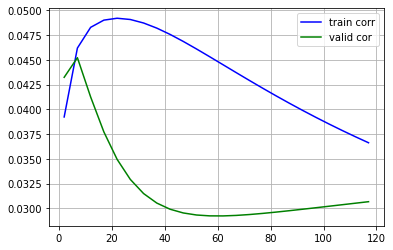

In [34]:
# optimal window size
train_cor = []
valid_cor = []
for ema_w in range(2, 120, 5):
    ema_window = ema_w
    train_cor.append(validate(ExponentialMA, log_pr_train, volu_train))
    valid_cor.append(validate(ExponentialMA, log_pr_test, volu_test))

import matplotlib.pyplot as plt
plt.plot(list(range(2, 120, 5)), train_cor, 'b-', label='train corr')
plt.plot(list(range(2, 120, 5)), valid_cor, 'g-', label='valid cor')
plt.legend()
plt.grid()
plt.show()

In [26]:
# mean pooling of working results
def average_prediction(A, B):
    pred = negative_return(A, B)
    pred += SimpleMA(A, B)
    pred += ExponentialMA(A, B)
    return pred / 3


In [27]:
validate(average_prediction, log_pr_train, volu_train)

84.67919659614563
0    0.044569
1    0.072417
2    0.009720
3    0.040864
4    0.114573
5    0.042672
6    0.102112
7    0.038349
8    0.118767
9    0.055179
dtype: float64
0.04723054218658617
